# Import block

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Lib.tab import tables_side

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df_air = pd.read_csv('df_air.csv',index_col=0)

In [4]:
df_covid = pd.read_csv('df_covid.csv', index_col=0)

In [5]:
df_demo = pd.read_csv('df_demo.csv',index_col=0)

# Main data table creation

In [6]:
df_summary = df_covid[['codice_regione', 'denominazione_regione', 'deceduti']]

In [7]:
df_summary = df_summary.merge(df_demo, left_on='denominazione_regione', right_on='denominazione_regione')

In [8]:
df_summary['death%'] = df_summary['deceduti']/df_summary['popolazione']*100

In [9]:
df_air_med = df_air.groupby(['Regione']).agg({'max media annuale (mg/m3)': ['count', 'mean', 'median']})

In [10]:
tables_side(titolo='Comparison between',
            tabs=[df_summary.sort_values(by='death%', ascending=False), df_air_med.sort_values(by=('max media annuale (mg/m3)', 'median'), ascending=False)],
            tabslabel=['Summary COVID ord by Death%','Summary Air Pollution'])

<b>Adesso ho due dataframe:</b>
* df_summary che contiene la lista delle regione, i deceduti e i deceduti in proporzione alla popolazione (più altri dati come popolazione e id regione
* df_air_med che contiene i valori di inquinamento dell'aria per regione, ho il calcolo della media e della mediana dei valori

Il mio obiettivo sarà riunire questi dati in un unico dataframe, per comodità accorperò tutto in <b>df_summary</b>, per l'inquinamento terrò solo la colonna della mediana

In [11]:
df_summary = df_summary.sort_values(by='death%', ascending=False).merge(df_air_med, left_on='denominazione_regione',right_on='Regione')
df_summary = df_summary.iloc[:,[0,1,2,3,4,7]]
df_summary.columns = ['codice_regione',
               'denominazione_regione',
                            'deceduti',
                         'popolazione',
                              'death%',
                     'air_poll_median']

In [12]:
df_summary.head(3)

,codice_regione,denominazione_regione,deceduti,popolazione,death%,air_poll_median
0,3,Lombardia,5944,10060574,0.059082,27.0
1,2,Valle d'Aosta,41,125666,0.032626,12.0
2,8,Emilia Romagna,1344,4459477,0.030138,18.5


In [13]:
df_covid_complete = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')

In [14]:
list_Regions = df_demo.denominazione_regione
dfCVprop = df_covid_complete[['data', 'denominazione_regione', 'deceduti','totale_ospedalizzati']]

In [15]:
for i in list_Regions:
    dfCVprop.loc[dfCVprop.denominazione_regione==i,'deceduti'] = dfCVprop.loc[dfCVprop.denominazione_regione==i,'deceduti']/df_demo[df_demo.denominazione_regione==i]['popolazione'].values*100
    dfCVprop.loc[dfCVprop.denominazione_regione==i,'totale_ospedalizzati'] = dfCVprop.loc[dfCVprop.denominazione_regione==i,'totale_ospedalizzati']/df_demo[df_demo.denominazione_regione==i]['popolazione'].values*100

In [16]:
df_main = dfCVprop.pivot_table(index='denominazione_regione', columns='data', values='deceduti').transpose()

In [17]:
df=df_covid_complete
lista_Regioni = df.denominazione_regione.unique()
tot = len(df[df['denominazione_regione']=='Lombardia'].loc[:,'deceduti'])

In [18]:
for l in lista_Regioni:
    dec = df[df.denominazione_regione==l]['deceduti'].index
    val =df[df.denominazione_regione==l]['deceduti'].values
    valosp =df[df.denominazione_regione==l]['totale_ospedalizzati'].values
    a = val[0]
    b = valosp[0]
    for x in range(1,tot):
        df.loc[dec[x-1],'nuovi_dec'] = a
        df.loc[dec[x-1],'nuovi_osp'] = b
        a = val[x]-val[x-1]
        b = valosp[x]-valosp[x-1]
    df.loc[dec[tot-1],'nuovi_dec'] = val[tot-1]-val[tot-2]
    df.loc[dec[tot-1],'nuovi_osp'] = valosp[tot-1]-valosp[tot-2]

### Conclusion
Adesso possiedo 4 tabelle di dati:
* <b>df_summary</b>: che contiene i dati delle regioni,riguardanti l'inquinamento dell'aria e dei morti in percentuale alla popolazione ('codice_regione', 'denominazione_regione', 'deceduti', 'popolazione', 'death%', 'air_poll_median')
* <b>df_covid_complete</b>: dataframe completo dal sito github della Protezione Civile, ha tutti le colonne originali
* <b>dfCVprop</b>: datateset di <b>df_covid_complete</b> da cui sono stati estrapolati solamente i dati relativi dalla data di rilevazione, regione e deceduti che sono stati normalizzati in base alla popolazione della regione
* <b>df_main</b>: semplicemente la tabella pivot del dataframe <b>dfCVprop</b> come colonne ha le regioni e come index ha la data delle rilevazioni, la tengo per comodità
* <b>df</b>: il dataframe originale df_covid_complete a cui ho aggiunto la progressione dei deceduti e degli ospedalizzati

# Data Exploration

Inizio ad esaminare l'andamento del contagio visualizzando il progressivo degli ospedalizzati e dei deceduti in 6 regioni scelte

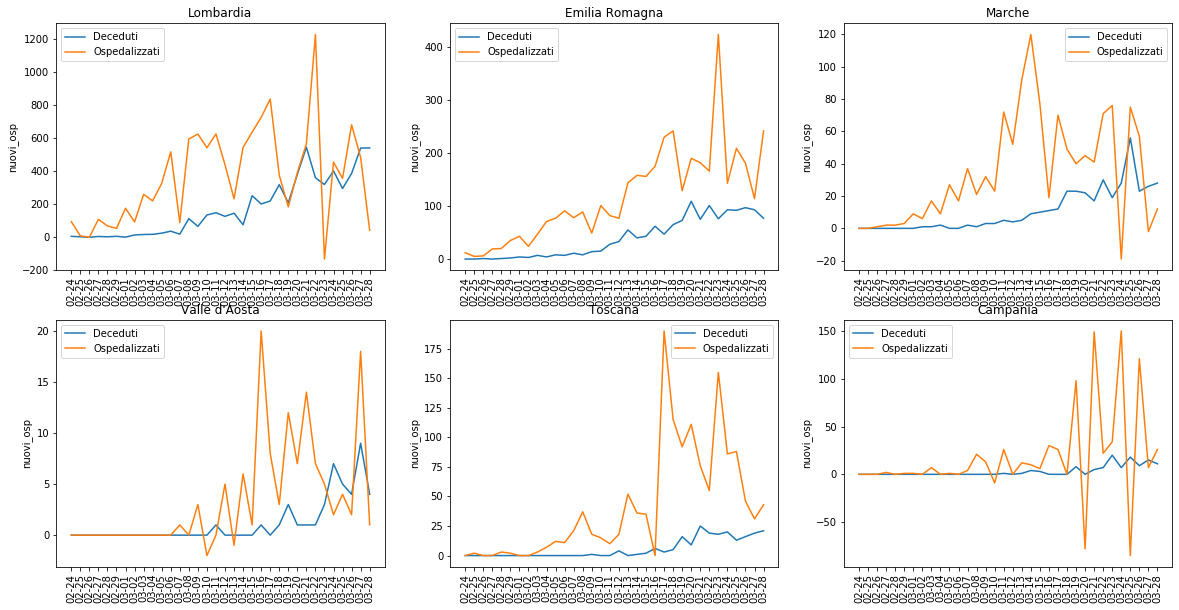

In [19]:
l = ['Lombardia', 'Emilia Romagna', 'Marche', "Valle d'Aosta", 'Toscana', 'Campania']
datagiorn=df.data.str[5:10]
plt.figure(figsize=(20,10))
for i, r in zip (l, range(len(l))):
    plt.subplot(2,3,r+1)
    sns.lineplot(x=datagiorn.unique(), y=df[df.denominazione_regione==i]['nuovi_dec'], label='Deceduti')
    sns.lineplot(x=datagiorn.unique(), y=df[df.denominazione_regione==i]['nuovi_osp'], label='Ospedalizzati')
    plt.title(i)
    plt.xticks(rotation=90)

Di seguito il Grafico dei morti in percentuale alla popolazione con la tabella relativa

Si può notare che, nonostante alcune regioni come ad esempio la Val d'Aosta, abbiano pochi morti assoluti, messi in relazione alla popolazione hanno un numero di morti più significativo


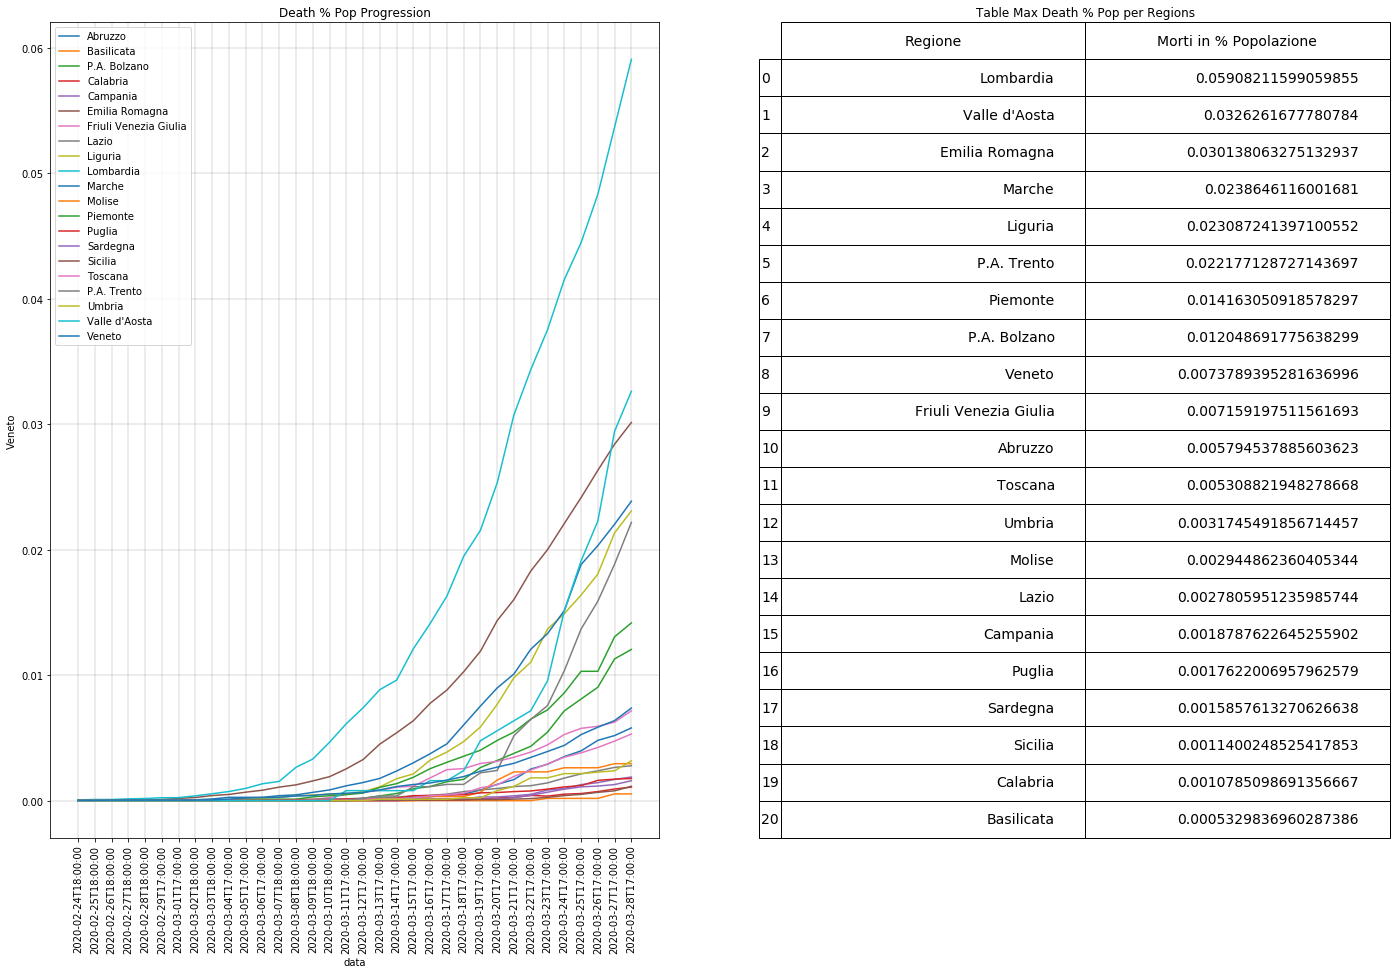

In [20]:
fig = plt.figure(figsize=(24,15))
ax1 = fig.add_subplot(121)

for i  in list_Regions:
    ax1=sns.lineplot(x=df_main.index, y=df_main.loc[:,i], label=i)
ax1.grid(color='gray', linestyle='-', linewidth=0.3)
ax1.legend()
plt.xticks(rotation=90)
plt.title('Death % Pop Progression')

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
plt.title('Table Max Death % Pop per Regions')

mpl_table = ax2.table(cellText = df_summary.iloc[:,[1,4]].sort_values(by='death%',ascending=False).values, rowLabels = df_summary.iloc[:,[1,4]].index, bbox=bbox, colLabels=['Regione','Morti in % Popolazione'],)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
print("Si può notare che, nonostante alcune regioni come ad esempio la Val d'Aosta, abbiano pochi morti assoluti, messi in relazione alla popolazione hanno un numero di morti più significativo")

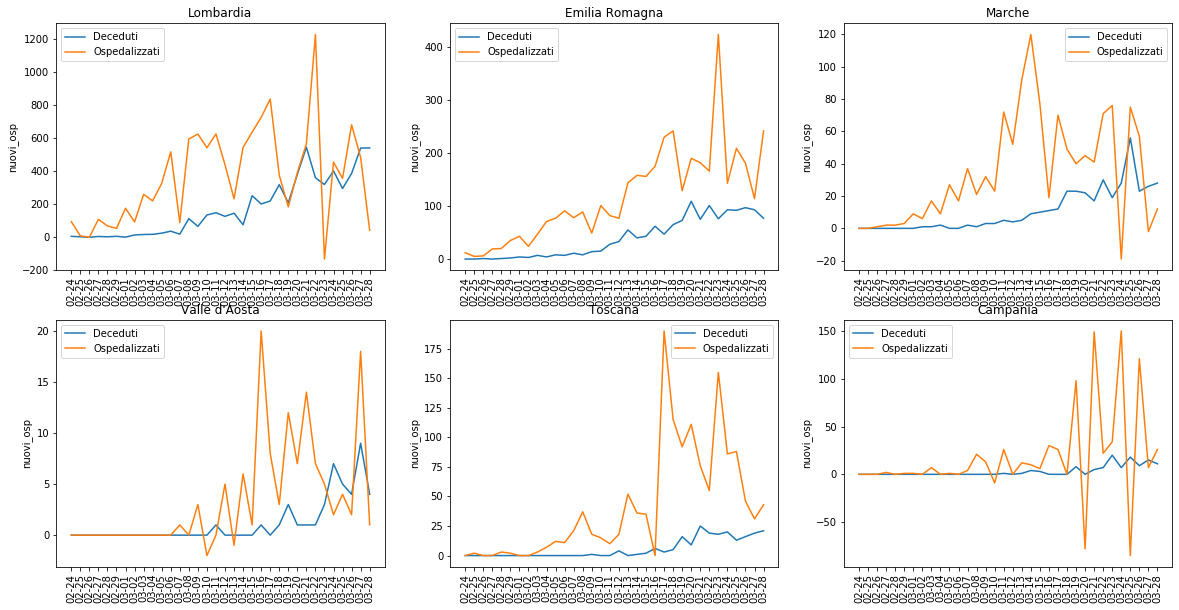

In [21]:
l = ['Lombardia', 'Emilia Romagna', 'Marche', "Valle d'Aosta", 'Toscana', 'Campania']
datagiorn=df.data.str[5:10]
plt.figure(figsize=(20,10))
for i, r in zip (l, range(len(l))):
    plt.subplot(2,3,r+1)
    sns.lineplot(x=datagiorn.unique(), y=df[df.denominazione_regione==i]['nuovi_dec'], label='Deceduti')
    sns.lineplot(x=datagiorn.unique(), y=df[df.denominazione_regione==i]['nuovi_osp'], label='Ospedalizzati')
    plt.title(i)
    plt.xticks(rotation=90)

Iniziamo a vedere se l'inquinamento è relazionambile con il numero di morti attraverso la correlazione delle features

In [22]:
heatmapshow = df_summary[['denominazione_regione',
                                       'deceduti',
                                         'death%',
                                    'popolazione',
                                'air_poll_median']].corr()


In [23]:
heatmapshow

,deceduti,death%,popolazione,air_poll_median
deceduti,1.000000,0.794909,0.720099,0.540927
death%,0.794909,1.000000,0.370823,0.279878
popolazione,0.720099,0.370823,1.000000,0.802277
air_poll_median,0.540927,0.279878,0.802277,1.000000


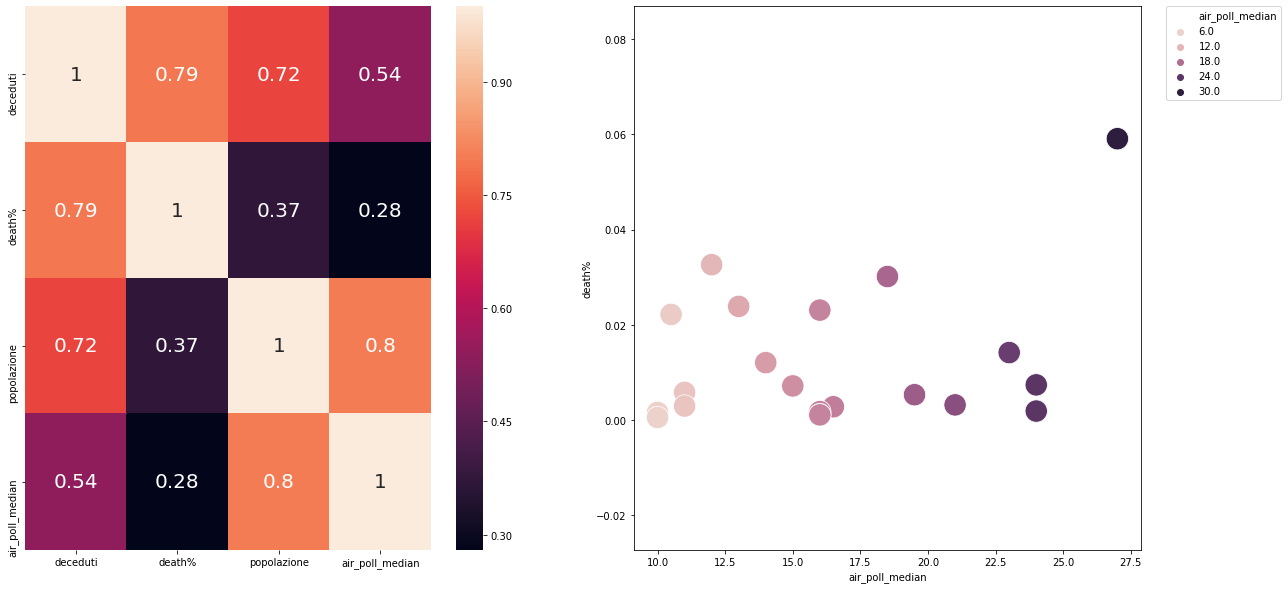

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(122)
sns.scatterplot(x=df_summary.iloc[:,5], y= df_summary['death%'], data=df_summary, hue='air_poll_median', s=500)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.subplot(121)
sns.heatmap(heatmapshow, annot=True, annot_kws={'size':20})

Da questa prima relazione i deceduti sembrano poco correlati all'inquinamento. Stesso risultato si può notare dallo scatterplot accanto.
***
Successivamente attraverso dei clustermap cerco relazioni tra regioni. Realizzerò un set di cluster (Normalizzato e Non Normalizzato):
* sui dati dei deceduti <u>NON proporzionati</u> alla popolazione 
* sui dati dei deceduti <u>proporzionati</u> alla popolazione

In [25]:
pivtable = df_covid_complete.pivot_table(index='denominazione_regione', columns='data', values='deceduti')

## Dati dei deceduti <u>NON proporzionati</u> alla popolazione

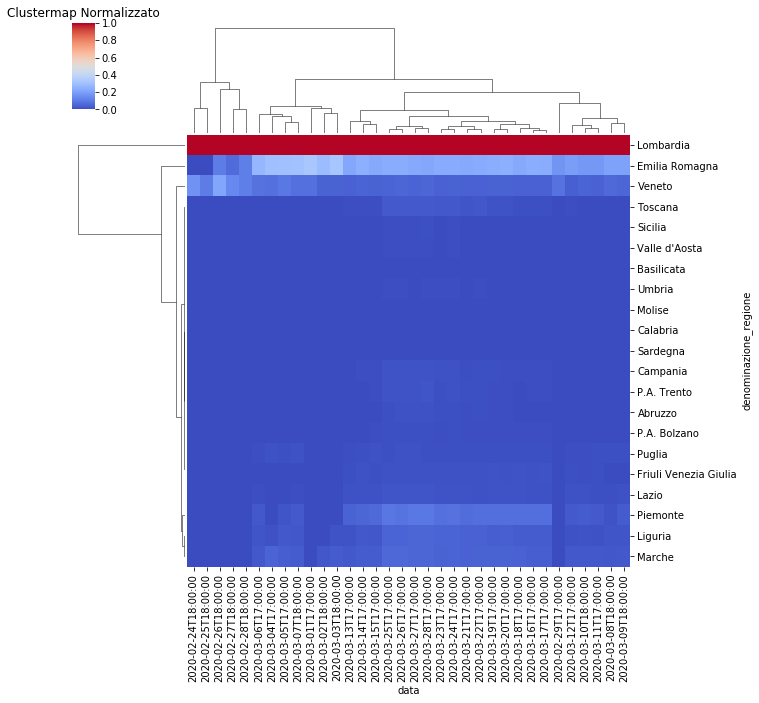

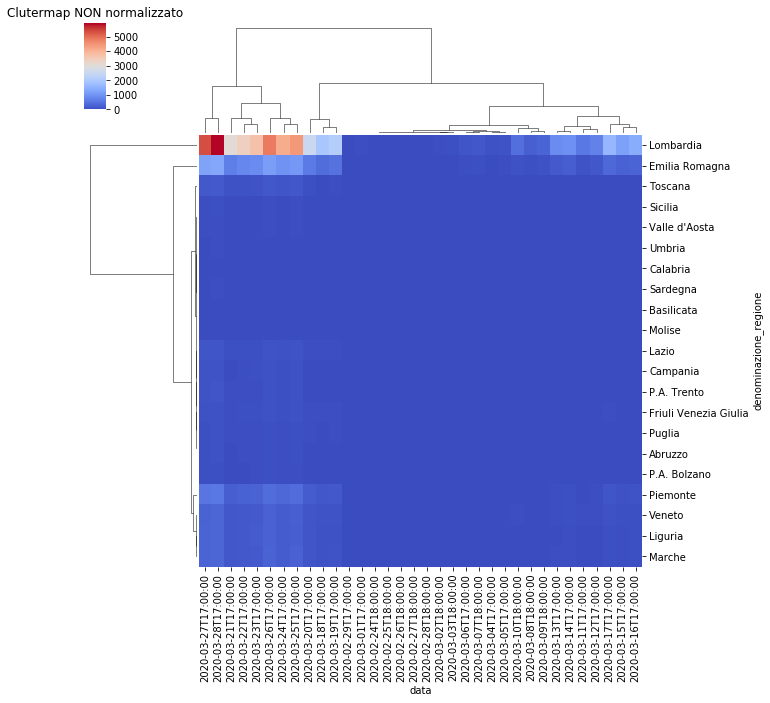

In [26]:
sns.clustermap(pivtable, cmap='coolwarm', standard_scale=1)
plt.title('Clustermap Normalizzato')

sns.clustermap(pivtable, cmap='coolwarm')
plt.title('Clutermap NON normalizzato')
plt.show()


## Dati dei deceduti <u>proporzionati</u> alla popolazione

Text(0.5, 1, 'Clustermap Normalizzato')

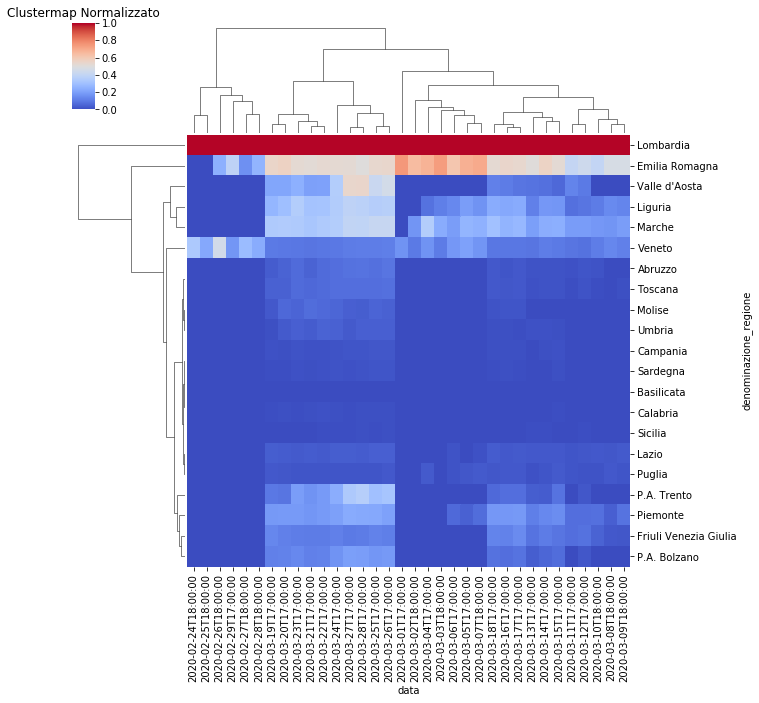

In [27]:
import matplotlib.gridspec
i='Emilia Romagna'
sns.clustermap(df_main.transpose(), cmap='coolwarm', standard_scale=1, figsize=(10,10))
plt.title('Clustermap Normalizzato')

In [28]:
l = ['Lombardia', 'Emilia Romagna', 'Marche', "Valle d'Aosta", 'Toscana', 'Campania', 'Molise']

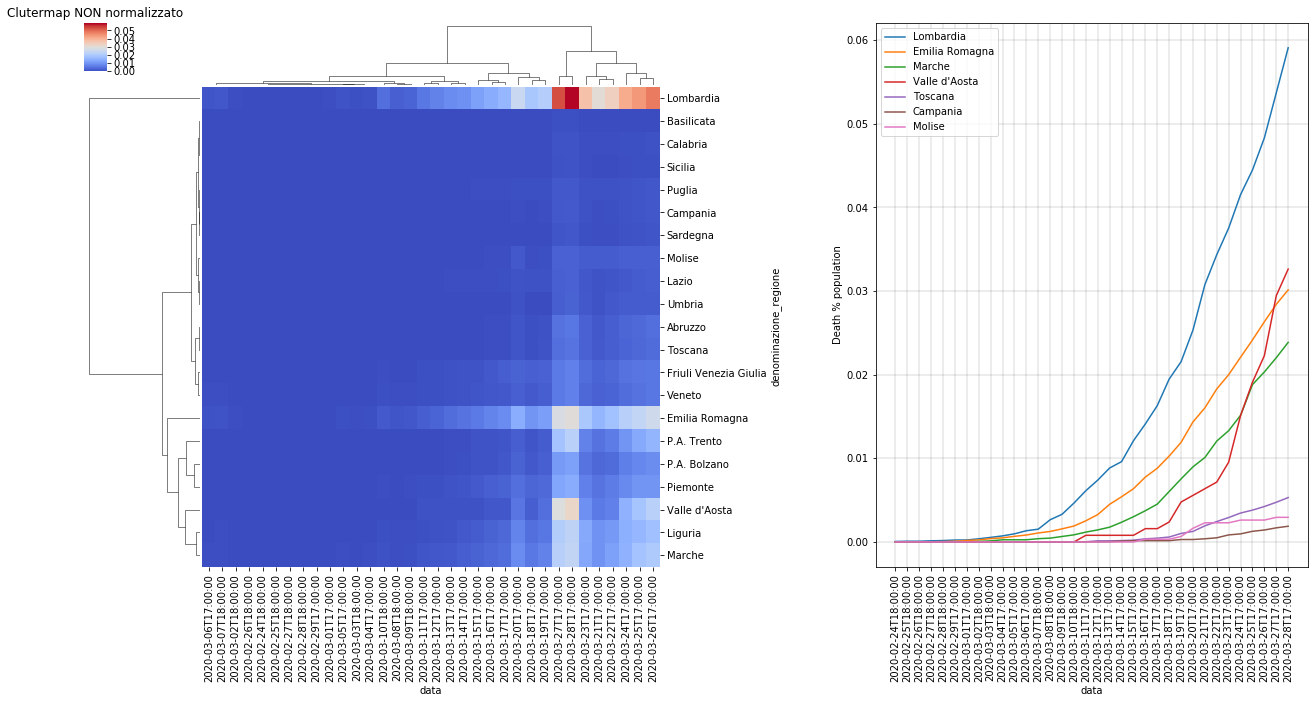

In [29]:
g = sns.clustermap(df_main.transpose(), cmap='coolwarm',figsize=(20,10))
g.gs.update(left=0.05, right=0.45)
plt.title('Clutermap NON normalizzato')
gs2 = matplotlib.gridspec.GridSpec(1,1, left=0.6)
ax2 = g.fig.add_subplot(gs2[0])
for i in l:
    sns.lineplot(x=df_main.index, y=df_main.loc[:,i], label=i, ax=ax2)
plt.ylabel('Death % population')
plt.grid(color='gray', linestyle='-', linewidth=0.3)
plt.xticks(rotation=90)
plt.legend(loc='upper left')


plt.show()

I dati proporzionati risultano a mio parere più visibili e dalla clustermap delineano la presenza di tre gruppi principali:
* Lombardia
* Marche, Liguria, Valle d'Aosta, Piemonte, Trentino Alto Adige, Emilia Romagna e Veneto
* le restanti regioni italiane
tale suddivisione si può notare anche dall'andamento delle linee dei decessi nel grafico accanto, anche meno chiaro.

Per ora per i dati visualizzati non mostrano una relazione evidente tra inquinamento e morte per polmonite interstiziale da Coronavirus, tuttavia la regione Lombardia, <u>l'unica con un valore superiore</u> a quelli consetiti dalla legge, è la regione che ha subito il maggior numero di decessi attribuiti all'azione del virus.

***

Per concludere questo processo di visualizzazione introduttiva dei dati realizzerò dei grafici geoplot per avere una visione forse più friendly dei dati.
Utilizzerò due libreire differenti con approcci diversi, da una parte geopandas e dall'altra ipyleaflet

In [30]:
import geopandas as gpd

In [31]:
# le librerie json che ho trovato in giro non hanno i nomi di provincie e regioni uguali a quelle delle mie tabelle
# devo in qualche modo uniformare per poterle mettere in relazione non perdere dati.
# voglio visualizzare dei grafici sia per regione che per provincia

# il file originale si può trovare qui, https://gist.github.com/datajournalism-it/f1abb68e718b54f6a0fe,
# le mie versioni SONO UNIFORMATE con le mie tabelle

reg_json = gpd.read_file('Lib/reg_ok_2020.geojson')

# il fle originale per le provincie si può trovare qui https://gist.github.com/datajournalism-it/212e7134625fbee6f9f7
prov_json = gpd.read_file('Lib/prov_ok_2020.geojson')


Il dataframe df_summary continene gia tutte le infomazioni che mi servono per la visualizzazione dei geoplot delle regioni, devo solo intergrare le coordinate dei poligoni che rappresentano le regioni contenuti nel file json

In [32]:
vis = reg_json.merge(df_summary, how='left', left_on='Regione', right_on = 'denominazione_regione')

In [33]:
vis['rate_poll'] = vis['air_poll_median']/vis['air_poll_median'].sum()
vis['rate_death'] = vis['death%']/vis['death%'].sum()

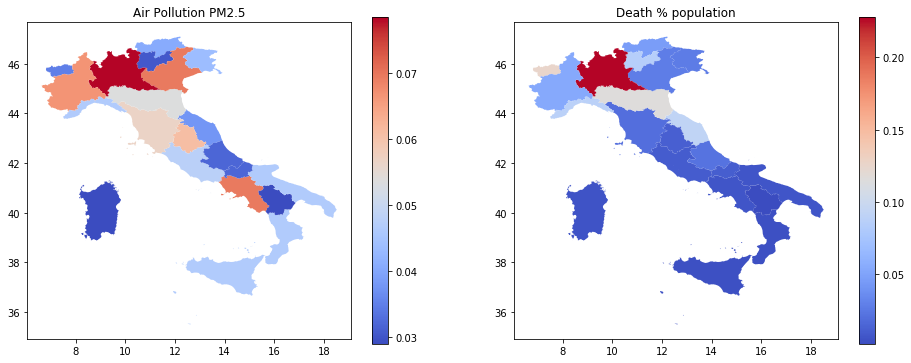

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].set_title('Air Pollution PM2.5')
vis.plot(column='rate_poll', ax=ax[0], cmap='coolwarm', legend=True)
ax[1].set_title('Death % population')
vis.plot(column='rate_death', ax=ax[1], cmap='coolwarm', legend=True)

plt.show()

Ad ora l'unica correlazione continua ad essere presente solo in Lombardia, è da ricordare che l'unica regione italiana ad avere un indice di inquinamento dell'aria maggiore alla soglia è la Lombardia.


***

Eseguirò la stessa cosa anche per le provincie, purtroppo il database di cui dispongo non ha numeri dei morti per provincia e dovrò utilizzare il valore degli ospedalizzati. Le problematiche sono quelle discusse all'inizio, sono dei dati che sono molto relativi, come quelli dei contagiati, e sopratutti in questo caso non ci sono neanche dati relativi al numero di posti letto per provincia, tuttavia proverò comunque a rapprensentarli.

In [35]:
ap_prov =  pd.read_excel('Data/air_pollution_data/Tabella 2.xlsx', header=1)
ap_prov[ap_prov['50° percentile1 [µg/m3]'].str.contains('-', na=False)]
ap_prov.drop(ap_prov[ap_prov['50° percentile1 [µg/m3]']=='-'].index, inplace=True)
ap_prov['50° percentile1 [µg/m3]']=pd.to_numeric(ap_prov['50° percentile1 [µg/m3]'])
df = ap_prov.groupby(by='Provincia').median()
df.columns = ['Region_id', 'Province_id', 'Municipality_id', 'Observation_id',
       'Station_code', 'airpoll', 'Numero di dati validi']
df.reset_index(inplace=True)

Dopo aver estrapolato i dati relativi all'inquinamento per provincia, raggruppo il numero di ospedalizzati per provincia e li accorpo le due tabelle.

In [36]:
df_covid_prov = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
df_covid_prov.loc[df_covid_prov['denominazione_provincia']=='Forlì-Cesena','denominazione_provincia'] = 'Forlì -Cesena'


In [46]:
df_covid_prov.loc[df_covid_prov['denominazione_provincia']=='In fase di definizione/aggiornamento','denominazione_provincia']
df_covid_prov.drop(df_covid_prov[df_covid_prov['denominazione_provincia']=='In fase di definizione/aggiornamento'].index, inplace=True)

In [39]:
df_prov = df_covid_prov.groupby('denominazione_provincia').median()
df_prov.reset_index(inplace=True)

In [40]:
df = df_prov.merge(df, how='left', left_on='denominazione_provincia', right_on='Provincia')

In [41]:
df = df.loc[:,['denominazione_provincia','totale_casi','airpoll']]
df['airpoll'].fillna(0, inplace=True)

In [42]:
df.head(3)

,denominazione_provincia,totale_casi,airpoll
0,Agrigento,16.5,11.000000
1,Alessandria,118.5,13.000000
2,Ancona,126.0,9.507143


Ora unisco la tabella ottenuta al json delle provincie

In [43]:
vis_prov = prov_json.merge(df, how='left', left_on='NOME_PRO', right_on = 'denominazione_provincia')

In [44]:
vis_prov['rate_poll'] = vis_prov['airpoll']/vis_prov['airpoll'].sum()
vis_prov['rate_death'] = vis_prov['totale_casi']/vis_prov['totale_casi'].sum()

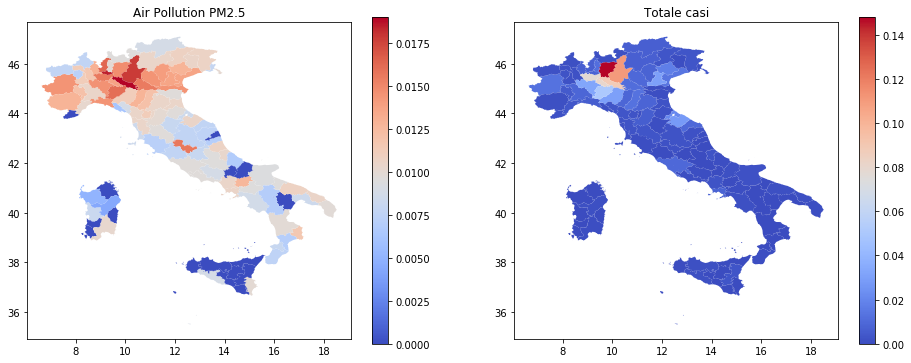

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
ax[0].set_title('Air Pollution PM2.5')
vis_prov.plot(column='rate_poll', ax=ax[0], cmap='coolwarm', legend=True)
ax[1].set_title('Totale casi')
vis_prov.plot(column='rate_death', ax=ax[1], cmap='coolwarm', legend=True)

plt.show()

Il totale dei casi non è proporzionato agli abitanti delle province per mancanza di dati. Appena possibile provvederò ad integrare questo dato.